<a href="https://colab.research.google.com/github/Ash100/Documents/blob/main/Genome_editing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧬 Fundamentals of Genome Editing and gRNA Design
Author: **Dr. Ashfaq Ahmad**

This notebook demonstration provides a practical demonstration of fundamental steps in genome editing, focusing on acquiring and manipulating DNA sequences, and then designing guide RNAs (gRNAs) for CRISPR-Cas9 systems.

---

## 📑 Table of Contents
1. [Sequence Acquisition and Manipulation](#sequence-acquisition-and-manipulation)  
    1.1. [Fetching a DNA Sequence from NCBI](#fetching-a-dna-sequence-from-ncbi)  
    1.2. [Basic Sequence Operations](#basic-sequence-operations)  
2. [Guide RNA (gRNA) Design](#guide-rna-grna-design)  
    2.1. [Identifying PAM Sites and Target Sequences](#identifying-pam-sites-and-target-sequences)  
    2.2. [gRNA Structure and Candidates](#grna-structure-and-candidates)  
    2.3. [Simplified Off-Target Consideration](#simplified-off-target-consideration)  
    2.4. [Simplified On-Target Efficiency (Conceptual)](#simplified-on-target-efficiency-conceptual)

**1. Setup and Dependencies**

Before we begin, we need to install the necessary Python libraries. Biopython is essential for handling biological sequences and interacting with online databases. pandas will be useful for organizing our gRNA candidates, and matplotlib for any potential visualizations.

In [ ]:
# Install necessary packages
!pip install biopython matplotlib

In [14]:
# Import required libraries
from Bio import Entrez, SeqIO, Seq
import matplotlib.pyplot as plt
import re
import os

# Set email for NCBI Entrez
Entrez.email = "abc#gmail.com"

**2. Sequence Acquisition and Manipulation**

In this section, we will acquire a DNA sequence, typically a gene or a genomic region of interest, from the NCBI database. We'll then perform some basic manipulations and analyses on this sequence.

**Instructions on Fetching a DNA Sequence from NCBI**

We'll use Biopython's Entrez module to search and fetch a DNA sequence. You'll need to provide an email address for Entrez access. For this example, let's fetch the human HBB (Beta globin) gene, which is a common target in genetic studies.

Note: Always replace "your.email@example.com" with your actual email address.

In [16]:
# Example: Fetch sequence using NCBI accession number
def fetch_sequence(accession):
    handle = Entrez.efetch(db="nucleotide", id=accession, rettype="fasta", retmode="text")
    record = SeqIO.read(handle, "fasta")
    handle.close()
    return record

record = fetch_sequence("DQ378290.1")  # Example: Drosophila virilis EGFR
print(record.description)
print(record.seq[:100])  # Preview first 100 bases

DQ378290.1 Drosophila virilis strain Tucson 15010-1001.10 fosmid 10J19, complete sequence
GATCTTTTGTTTTCTTTAAAGTTCTAAGAAGACATGTTGCCCTGAACATCTAAAATAGAGATTTTCTAGATTTTTTTACGAGAGTCTGTAGTAGATAGAC


Let's perform basic sequence operations such as computing the reverse complement, transcription, and GC content.


In [21]:
from Bio.SeqUtils import gc_fraction

sequence = record.seq[:34000]  # Work with a small fragment
rev_comp = sequence.reverse_complement()
transcribed = sequence.transcribe()
gc = gc_fraction(sequence) * 100

print(f"Original: {sequence[:50]}")
print(f"Rev Comp: {rev_comp[:50]}")
print(f"Transcribed: {transcribed[:50]}")
print(f"GC Content: {gc:.2f}%")

Original: GATCTTTTGTTTTCTTTAAAGTTCTAAGAAGACATGTTGCCCTGAACATC
Rev Comp: CGTATTTACCTCGACTCATATCTGTATCTGTATCTGTGTCTGTATCTGTA
Transcribed: GAUCUUUUGUUUUCUUUAAAGUUCUAAGAAGACAUGUUGCCCUGAACAUC
GC Content: 44.29%


2. Guide RNA (gRNA) Design
2.1 Identifying PAM Sites and Target Sequences
In CRISPR-Cas9, the PAM sequence is typically 'NGG' (where N = any nucleotide). Let's identify candidate target sequences (20 bp upstream of PAM).

In [31]:
#@title Forward Strand only
import re

def find_pam_sites(seq, guide_length=20):
    """
    Find CRISPR gRNA targets on the forward strand with NGG PAM.
    Returns a list of (gRNA, start, end) tuples.
    """
    seq_str = str(seq).upper()
    candidates = []

    for i in range(len(seq_str) - guide_length - 3):
        guide = seq_str[i:i + guide_length]
        pam = seq_str[i + guide_length:i + guide_length + 3]
        if re.match(r'^[ACGT]GG$', pam):  # Matches NGG
            start = i + 1  # 1-based
            end = i + guide_length
            candidates.append((guide, start, end))

    return candidates

In [32]:
# Analyze first 2000 bases of your sequence
sequence = record.seq[:2000]

candidates = find_pam_sites(sequence)
print(f"Found {len(candidates)} potential gRNAs on forward strand\n")

# Display first 5 results with positions
for gRNA, start, end in candidates[:5]:
    print(f"gRNA: {gRNA}\nStart: {start}\tEnd: {end}\n{'-'*40}")

Found 78 potential gRNAs on forward strand

gRNA: TAGTAGATAGACTTTTAGCT
Start: 89	End: 108
----------------------------------------
gRNA: AGTAGATAGACTTTTAGCTC
Start: 90	End: 109
----------------------------------------
gRNA: TAGCTCGGGTTGTCATTTAA
Start: 104	End: 123
----------------------------------------
gRNA: AGCTCGGGTTGTCATTTAAT
Start: 105	End: 124
----------------------------------------
gRNA: TCGGGTTGTCATTTAATGGG
Start: 108	End: 127
----------------------------------------


In [29]:

import re

def find_pam_sites_both_strands(seq, guide_length=20):
    """
    Finds CRISPR gRNA targets followed by NGG PAM on both DNA strands.
    Returns a list of tuples: (gRNA sequence, strand, start, end)
    """
    seq_str = str(seq).upper()
    rev_seq_str = str(seq.reverse_complement()).upper()
    gRNAs = []

    # Forward strand
    for i in range(len(seq_str) - guide_length - 3):
        guide = seq_str[i:i + guide_length]
        pam = seq_str[i + guide_length:i + guide_length + 3]
        if re.match(r'^[ACGT]GG$', pam):  # PAM = NGG
            start = i + 1  # 1-based
            end = i + guide_length
            gRNAs.append((guide, 'forward', start, end))

    # Reverse strand
    for i in range(len(rev_seq_str) - guide_length - 3):
        guide = rev_seq_str[i:i + guide_length]
        pam = rev_seq_str[i + guide_length:i + guide_length + 3]
        if re.match(r'^[ACGT]GG$', pam):  # PAM = NGG
            # Convert reverse complement coordinates to original
            end = len(seq) - i
            start = end - guide_length + 1
            gRNAs.append((guide, 'reverse', start, end))

    return gRNAs


In [30]:
sequence = record.seq[:2000]  # Limit for demo

candidates = find_pam_sites_both_strands(sequence)
print(f"Found {len(candidates)} gRNA candidates on both strands\n")

# Nicely format the output
for gRNA, strand, start, end in candidates[:10]:  # Show first 10
    print(f"gRNA: {gRNA}\nStrand: {strand}\nStart: {start}\tEnd: {end}\n{'-'*40}")


Found 162 gRNA candidates on both strands

gRNA: TAGTAGATAGACTTTTAGCT
Strand: forward
Start: 89	End: 108
----------------------------------------
gRNA: AGTAGATAGACTTTTAGCTC
Strand: forward
Start: 90	End: 109
----------------------------------------
gRNA: TAGCTCGGGTTGTCATTTAA
Strand: forward
Start: 104	End: 123
----------------------------------------
gRNA: AGCTCGGGTTGTCATTTAAT
Strand: forward
Start: 105	End: 124
----------------------------------------
gRNA: TCGGGTTGTCATTTAATGGG
Strand: forward
Start: 108	End: 127
----------------------------------------
gRNA: TTGTCATTTAATGGGCGGCT
Strand: forward
Start: 113	End: 132
----------------------------------------
gRNA: TGTCATTTAATGGGCGGCTA
Strand: forward
Start: 114	End: 133
----------------------------------------
gRNA: TATATATTATGTTTATAATA
Strand: forward
Start: 174	End: 193
----------------------------------------
gRNA: ATATATTATGTTTATAATAA
Strand: forward
Start: 175	End: 194
----------------------------------------
gRNA: GTATTGCCTTTTGCTGT

2.2 gRNA Structure and Candidates

Each candidate contains a 20 bp target followed by a PAM. This structure is critical for Cas9 binding.
We can visualize the distribution of PAM sites across the sequence.

In [34]:
import matplotlib.pyplot as plt

def plot_gRNA_distribution(seq, candidates):
    """
    Plots gRNA start positions as red ticks along the sequence.
    Expects `candidates` as list of (gRNA, start, end) tuples.
    """
    positions = [start for _, start, _ in candidates]  # Extract start positions
    plt.figure(figsize=(10, 2))
    plt.plot(positions, [1]*len(positions), '|', color='red', markersize=10)
    plt.title("gRNA Target Sites (Forward Strand)")
    plt.yticks([])
    plt.xlabel("Nucleotide Position")
    plt.tight_layout()
    plt.savefig("gRNA_distribution.png", dpi=600)
    plt.show()

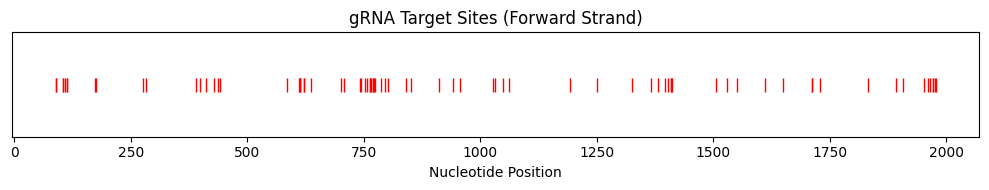

In [35]:
# After you've run find_pam_sites
plot_gRNA_distribution(sequence, candidates)

In [45]:
import matplotlib.pyplot as plt

def plot_gRNA_distribution_both_strands(seq, candidates):
    forward_pos = [start for _, strand, start, _ in candidates if strand == 'forward']
    reverse_pos = [start for _, strand, start, _ in candidates if strand == 'reverse']

    plt.figure(figsize=(12, 3))
    plt.plot(forward_pos, [1]*len(forward_pos), '|', color='red', markersize=12, label='Forward Strand')
    plt.plot(reverse_pos, [0]*len(reverse_pos), '|', color='blue', markersize=12, label='Reverse Strand')

    plt.yticks([0, 1], ["Reverse", "Forward"])
    plt.xlabel("Nucleotide Position")
    plt.title("gRNA Target Sites on Both Strands")
    plt.tight_layout()

    # Legend outside the plot on the right
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.savefig("gRNA_distribution_both_strands.png", dpi=600, bbox_inches='tight')  # save with tight bbox to include legend
    plt.show()

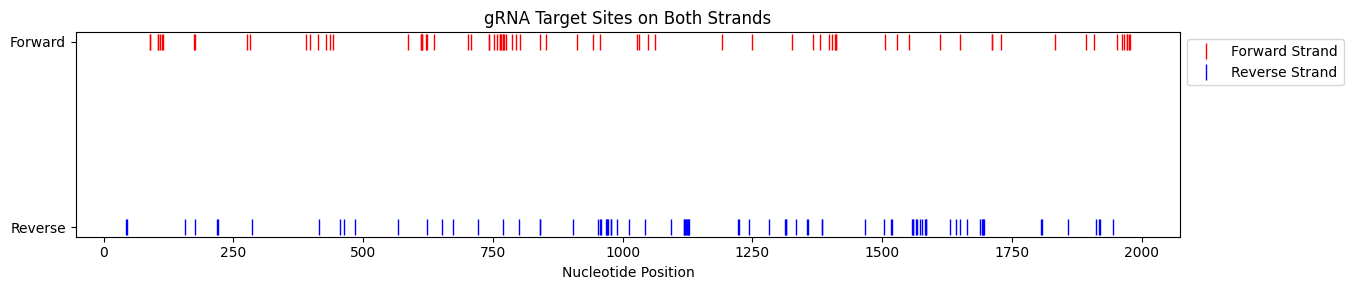

In [46]:
sequence = record.seq[:2000]
candidates = find_pam_sites_both_strands(sequence)
plot_gRNA_distribution_both_strands(sequence, candidates)

2.3 Simplified Off-Target Consideration
Off-targets can occur if similar sequences exist elsewhere. We'll demonstrate a naive method: count number of perfect duplicates in a larger context.


In [56]:
def naive_off_target(grna_list, genome_seq, max_off=1):
    """
    Counts exact matches of each gRNA in the genome.
    Reports gRNAs with count > max_off (potential off-target risk).
    """
    off_target_counts = []
    for grna in grna_list:
        count = genome_seq.count(grna)
        if count > max_off:
            off_target_counts.append((grna, count))
    return off_target_counts

**Why no off-targets are printed?**
1. Our **`max_off`** is set to 2, so only gRNAs that appear 3 or more times will be reported.

2. Your genome snippet might be small or unique enough that no gRNA sequence repeats that often exactly.

3. The search is exact matches only — no mismatches considered, so off-targets with mismatches won't be detected here.

4. If you ran on just a small fragment (like 5000 bp) instead of the full genome, chances for repeats decrease.

2.4 Simplified On-Target Efficiency (Conceptual)
While on-target efficiency is model-based, a simplistic indicator can be GC content of the guide region (ideal range: 40–60%).

In [64]:
def gc_fraction(seq):
    seq = seq.upper()
    gc_count = seq.count('G') + seq.count('C')
    return gc_count / len(seq)

In [68]:
# Extract just sequences from candidates
gRNA_sequences = [g[0] for g in candidates]

def guide_gc_efficiency(gRNAs):
    result = []
    for g in gRNAs:
        gc = gc_fraction(g) * 100
        result.append((g, gc))
    return result

efficiency_scores = guide_gc_efficiency(gRNA_sequences)
filtered = [g for g in efficiency_scores if 40 <= g[1] <= 60]

print(f"{len(filtered)} guides have ideal GC content (40–60%).")
print(filtered[:5])

77 guides have ideal GC content (40–60%).
[('TAGCTCGGGTTGTCATTTAA', 40.0), ('AGCTCGGGTTGTCATTTAAT', 40.0), ('TCGGGTTGTCATTTAATGGG', 45.0), ('TTGTCATTTAATGGGCGGCT', 45.0), ('TGTCATTTAATGGGCGGCTA', 45.0)]


✅ Suggested Enhancements for Professional CRISPR gRNA Design Notebook
🧩 1. Interactive Widgets (Using ipywidgets)
Purpose: Allow users to:

Choose accession number interactively

Set gRNA length, PAM type

Filter guides by GC content

In [11]:
!pip install ipywidgets
import ipywidgets as widgets
from IPython.display import display

# Accession input
accession_widget = widgets.Text(
    value='NC_000913.3',
    placeholder='Enter NCBI Accession',
    description='Accession:',
    disabled=False
)

# PAM pattern
pam_widget = widgets.Text(
    value='NGG',
    placeholder='e.g., NGG',
    description='PAM:',
)

# gRNA length
length_widget = widgets.IntSlider(
    value=20,
    min=18,
    max=23,
    step=1,
    description='gRNA Length:'
)

# GC filter
gc_range_widget = widgets.FloatRangeSlider(
    value=[40, 60],
    min=0,
    max=100,
    step=1,
    description='GC Range:'
)

display(accession_widget, pam_widget, length_widget, gc_range_widget)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.6 MB/s eta 0:00:00


Text(value='NC_000913.3', description='Accession:', placeholder='Enter NCBI Accession')

Text(value='NGG', description='PAM:', placeholder='e.g., NGG')

IntSlider(value=20, description='gRNA Length:', max=23, min=18)

FloatRangeSlider(value=(40.0, 60.0), description='GC Range:', step=1.0)

🧬 2. BLAST Search for Off-Target Analysis (More Realistic)
Purpose: Check if a candidate guide occurs elsewhere in the genome.

In [12]:
from Bio.Blast import NCBIWWW, NCBIXML

def run_blast_off_target(gRNA):
    print("Running BLAST...")
    result_handle = NCBIWWW.qblast("blastn", "nt", gRNA, hitlist_size=5)
    blast_record = NCBIXML.read(result_handle)

    for alignment in blast_record.alignments:
        for hsp in alignment.hsps:
            print(f"Match: {alignment.title}")
            print(f"Score: {hsp.score}, E-value: {hsp.expect}")
            print(f"Match: {hsp.sbjct}\n")

In [13]:
# Run BLAST for a top candidate (USE WITH CAUTION: rate-limited)
run_blast_off_target(candidates[0])

IndexError: list index out of range